# Table of Contents:
1. [Introduction](#section-one)

2. [Preprocessing and Cleaning](#section-two)

3. [Data  Visualization for News](#section-three)

4. [Stemming & Vectorizing](#section-four)

5. [Model Building: Fake news Classifier](#section-five)

6. [Deep Learning-LSTM](#section-six)

7. [Conclusion](#section-seven)

<a id="section-one"></a>
# Introduction

Fake news is like a wildfire in the age of social media, especially during critical events like elections and pandemics such as Covid-19. It's spreading like a contagion, and it's becoming increasingly difficult to separate fact from fiction amidst the information overload. Taiwan, in the recent wave of Covid-19, has seen a deluge of fake news flooding platforms like LINE, Facebook, and PTT, a popular online forum. What's alarming is that many seniors are inadvertently contributing to the chaos by sharing these unverified messages. To combat this, our mission is to employ the power of cutting-edge artificial intelligence algorithms to swiftly identify and expose fake news, helping people stay informed and making the online world a more reliable place.

## Problem statement
The problem is to develop a fake news detection model using a Kaggle dataset.
The goal is to distinguish between genuine and fake news articles based on their titles and text.
This project involves using natural language processing (NLP) techniques to preprocess the text data, building a machine learning model for classification, and evaluating the model's performance.


## Objective
1. Our sole objective is to classify the news  from the dataset to fake or true news. 
2. Extensive EDA of news
3. Selection and development of a robust classification model

## Import Libraries
Let's import all necessary libraries for the analysis and along with it let's bring down our dataset

In [2]:
#Basic libraries
import pandas as pd 
import numpy as np 

#Visualization libraries
import matplotlib.pyplot as plt 
import seaborn as sns
from textblob import TextBlob
import plotly.graph_objs as go
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#NLTK libraries
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Machine Learning libraries
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
 

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#Miscellanous libraries
from collections import Counter

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Deep learning libraries
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

c:\Users\Roshan Elesius\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning:

Blowfish has been deprecated



## Importing the dataset
Let's introduce our dataset and explore its contents

In [3]:
#reading the fake and true datasets
fake_news = pd.read_csv('Fake.csv')
true_news = pd.read_csv('True.csv')

# print shape of fake dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(fake_news.shape))
print (fake_news.info())
print("\n --------------------------------------- \n")

# print shape of true dataset with rows and columns and information
print ("The shape of the  data is (row, column):"+ str(true_news.shape))
print (true_news.info())

The shape of the  data is (row, column):(23481, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None

 --------------------------------------- 

The shape of the  data is (row, column):(21417, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


## Dataset Details
This metadata has two csv files where one dataset contains fake news and the other contains true/real news and has nearly **23481 fake news and 21417 true news**

**Description of columns in the file:**

* title- contains news headlines
* text-contains news content/article
* subject- type of news
* date- date the news was published

<a id="section-two"></a>
# Preprocessing and Cleaning
We have to perform certain preprocessing steps before performing EDA and giving the data to the model.Let's begin with creating the output column

## Creating the target column 
Let's create the target column for both fake and true news. Here we are gonna denote the target value as '0' incase of fake news and '1' incase of true news

In [4]:
#Target variable for fake news
fake_news['output']=0

#Target variable for true news
true_news['output']=1

## Concatenating title and text of news
News has to be classified based on the tile and text jointly. Treating the title and content of news separately doesn't reap us any benefit. So, lets concatenate both the columns in both datasets

In [5]:
#Concatenating and dropping for fake news
fake_news['news']=fake_news['title']+fake_news['text']
fake_news=fake_news.drop(['title', 'text'], axis=1)

#Concatenating and dropping for true news
true_news['news']=true_news['title']+true_news['text']
true_news=true_news.drop(['title', 'text'], axis=1)

#Rearranging the columns
fake_news = fake_news[['subject', 'date', 'news','output']]
true_news = true_news[['subject', 'date', 'news','output']]

## Converting the date columns to datetime format
We can use pd.datetime to convert our date columns to date format we desire. But there was a problem,especially in fake_news date column. Let's check the value_counts() to see what lies inside

In [6]:
fake_news['date'].value_counts()

May 10, 2017         46
May 26, 2016         44
May 6, 2016          44
May 5, 2016          44
May 11, 2016         43
                     ..
December 9, 2017      1
December 4, 2017      1
November 19, 2017     1
November 20, 2017     1
Jul 19, 2015          1
Name: date, Length: 1681, dtype: int64

If you notice, we had links and news headline inside the date column which can give us trouble when converting to datetime format. So let's remove those records from the column 

In [7]:
#Removing links and the headline from the date column
fake_news=fake_news[~fake_news.date.str.contains("http")]
fake_news=fake_news[~fake_news.date.str.contains("HOST")]

'''You can also execute the below code to get the result 
which allows only string which has the months and rest are filtered'''
#fake_news=fake_news[fake_news.date.str.contains("Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec")]


'You can also execute the below code to get the result \nwhich allows only string which has the months and rest are filtered'

Only fake news dataset had an issue with date column,Now let's proceed with converting the date column to datetime format

In [8]:
#Converting the date to datetime format
fake_news['date'] = pd.to_datetime(fake_news['date'])
true_news['date'] = pd.to_datetime(true_news['date'])

## Appending two datasets
When we are providing a dataset for the model, we have to provide it as a single file. So it's better to append both true and fake news data and preprocess it further and perform EDA

In [9]:
frames = [fake_news, true_news]
news_dataset = pd.concat(frames)
news_dataset

subject       date  \
0           News 2017-12-31   
1           News 2017-12-31   
2           News 2017-12-30   
3           News 2017-12-29   
4           News 2017-12-25   
...          ...        ...   
21412  worldnews 2017-08-22   
21413  worldnews 2017-08-22   
21414  worldnews 2017-08-22   
21415  worldnews 2017-08-22   
21416  worldnews 2017-08-22   

                                                    news  output  
0       Donald Trump Sends Out Embarrassing New Year’...       0  
1       Drunk Bragging Trump Staffer Started Russian ...       0  
2       Sheriff David Clarke Becomes An Internet Joke...       0  
3       Trump Is So Obsessed He Even Has Obama’s Name...       0  
4       Pope Francis Just Called Out Donald Trump Dur...       0  
...                                                  ...     ...  
21412  'Fully committed' NATO backs new U.S. approach...       1  
21413  LexisNexis withdrew two products from Chinese ...       1  
21414  Minsk cultural hub becomes haven from authorit...       1  
21415  Vatican upbeat on possibility of Pope Francis ...       1  
21416  Indonesia to buy $1.14 billion worth of Russia...       1  

[44888 rows x 4 columns]

## Text Processing
This is an important phase for any text analysis application.There will be many unuseful content in the news which can be an obstacle when feeding to a machine learning model.Unless we remove them the machine learning model doesn't work efficiently. Lets go step by step.

## News-Punctuation Cleaning
Let's begin our text processing by removing the punctuations

In [10]:
#Creating a copy 
clean_news=news_dataset.copy()

In [11]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [12]:
clean_news['news']=clean_news['news'].apply(lambda x:review_cleaning(x))
clean_news.head()

subject       date                                               news  \
0    News 2017-12-31   donald trump sends out embarrassing new year’...   
1    News 2017-12-31   drunk bragging trump staffer started russian ...   
2    News 2017-12-30   sheriff david clarke becomes an internet joke...   
3    News 2017-12-29   trump is so obsessed he even has obama’s name...   
4    News 2017-12-25   pope francis just called out donald trump dur...   

   output  
0       0  
1       0  
2       0  
3       0  
4       0

We have removed all punctuation in our news column

## News-Stop words
A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.
We would not want these words to take up space in our database, or taking up valuable processing time. For this, we can remove them easily, by storing a list of words that you consider to stop words. NLTK(Natural Language Toolkit) in python has a list of stopwords stored in 16 different languages. Source: [Geeks for Geeks](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)

For our project, we are considering the english stop words and removing those words

In [13]:
stop = stopwords.words('english')
clean_news['news'] = clean_news['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

subject       date                                               news  \
0    News 2017-12-31  donald trump sends embarrassing new year’s eve...   
1    News 2017-12-31  drunk bragging trump staffer started russian c...   
2    News 2017-12-30  sheriff david clarke becomes internet joke thr...   
3    News 2017-12-29  trump obsessed even obama’s name coded website...   
4    News 2017-12-25  pope francis called donald trump christmas spe...   

   output  
0       0  
1       0  
2       0  
3       0  
4       0

We have removed all the stop words in the review column

<a id="section-three"></a>
# Data  Visualization for News

In this section we will complete do exploratory data analysis on news such as ngram analysis and understand which are all the words,context which are most likely found in fake news

## Count of news subject
Let's start by looking at the count of news types in our dataset

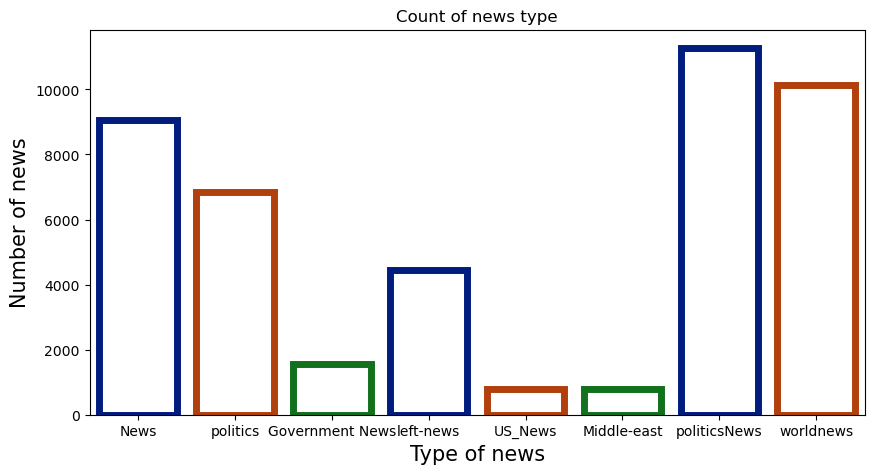

In [14]:
#Plotting the frequency plot
ax = sns.countplot(x="subject", data=clean_news,
                   facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 3))

#Setting labels and font size
ax.set(xlabel='Type of news', ylabel='Number of news',title='Count of news type')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

**Insights:**
* Our dataset has more political news than any other news followed by world news
* We have some repeated class names which expresses same meaning such as news,politics,government news etc which is similar to the alternative

## Count of news subject based on true or fake 
Lets look at the count based on the fake/true outcome.

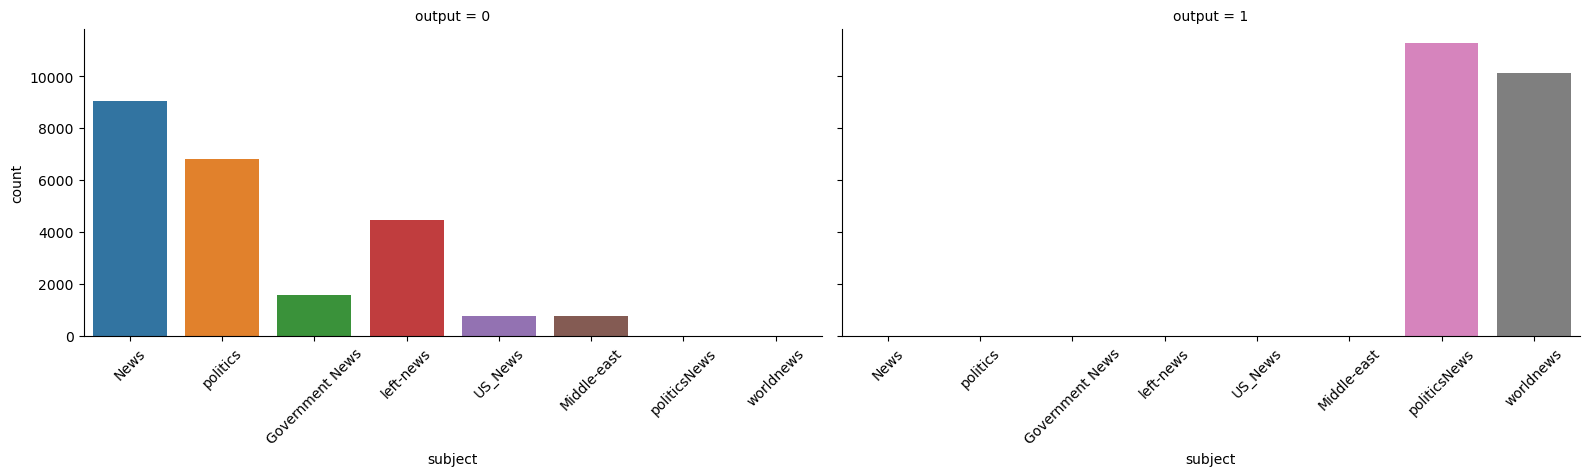

In [15]:
g = sns.catplot(x="subject", col="output",
                data=clean_news, kind="count",
                height=4, aspect=2)

#Rotating the xlabels
g.set_xticklabels(rotation=45)

**Insights:**
* Fake news are all over the category except politics and world news 
* True news are present only in politics and world news and the count is high
* THIS IS A HIGHLY BIASED DATASET and we can expect higher accuracy which doesn't signify it is a good model considering the poor quality of dataset

## Count of fake news and true news
Let's check the count of fake and true news and confirm whether our data is balanced or not

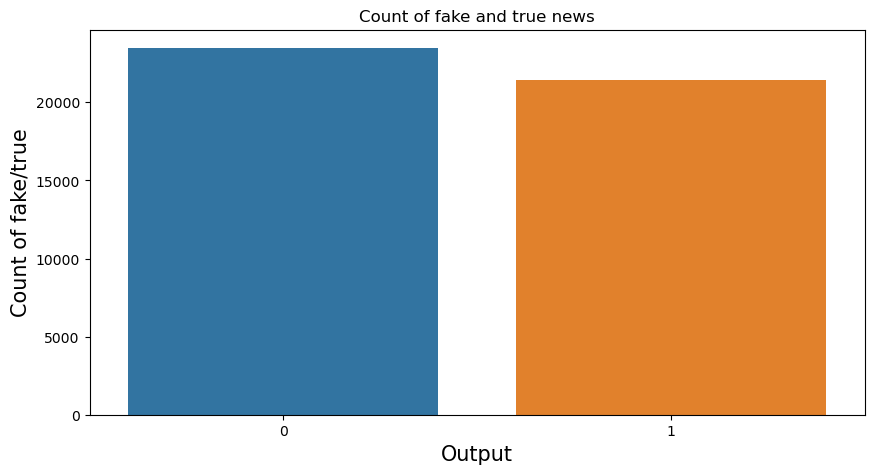

In [16]:
ax=sns.countplot(x="output", data=clean_news)

#Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

**Insights:**
* We have a pretty much balanced data 
* But the count of fake news is higher than the true news but not on a greater extent

## Deriving new features from the news
Lets extract more features from the news feature such as
1. Polarity: The measure which signifies the sentiment of th news
2. Review length: Length of the news(number of letters and spaces)
3. Word Count: Number of words in the news

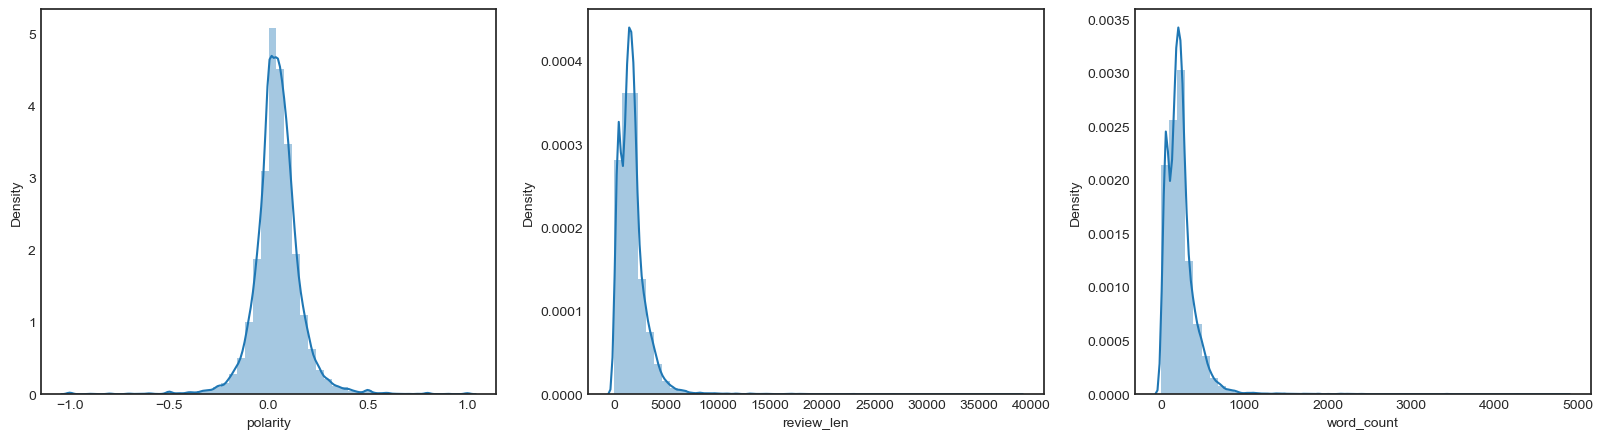

In [17]:
#Extracting the features from the news
clean_news['polarity'] = clean_news['news'].map(lambda text: TextBlob(text).sentiment.polarity)
clean_news['review_len'] = clean_news['news'].astype(str).apply(len)
clean_news['word_count'] = clean_news['news'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(clean_news['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(clean_news['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(clean_news['word_count'])
fig = plt.gcf()

**Insights:**
* Most of the polarity are neutral, neither it shows some bad news nor much happy news
* The word count is between 0-1000 and the length of the news are between 0-5000 and few near 10000 words which could be an article

## N-gram analysis

### Top 20 words in News
Let's look at the top 20 words from the news which could give us a brief idea on what news are popular in our dataset

In [18]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(clean_news['news'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df1.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in news')


trump 140400
said 130258
us 68081
would 55422
president 53189
people 41718
one 36146
state 33190
new 31799
also 31209
obama 29881
clinton 29003
house 28716
government 27392
donald 27376
reuters 27348
states 26331
republican 25287
could 24356
white 23823


**Insights:**
* All the top 20 news are about the US government 
* Especially it's about Trump and US followed by obama
* We can understand that the news are from reuters.

### Top 2 words in the news
Now let's expand our search to top 2 words from the news

In [19]:
#Function to get top bigram words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_bigram(clean_news['news'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)
    
#Creating the dataframe of word and frequency
df3 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df3.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in news')


donald trump 25059
united states 18394
white house 15485
hillary clinton 9502
new york 8110
north korea 7053
president donald 6928
image via 6188
barack obama 5603
trump said 4816
prime minister 4753
president trump 4646
supreme court 4595
last year 4560
last week 4512
said statement 4425
fox news 4074
president obama 4065
islamic state 4014
national security 3858


**Insights:**
* As feared, I think the model will be biased in it's results considering the amount of trump news
* We can see the north korea news as well, I think it will be about the dispute between US and NK
* There are also few news from fox news as well

In [20]:
#Function to get top trigram words
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_trigram(clean_news['news'], 20)

#Printing word and their respective frequencies
for word, freq in common_words:
    print(word, freq)

#Creating a dataframe with words and count
df6 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Grouping the words and plotting their frequencies
df6.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in news')


president donald trump 6808
president barack obama 3735
new york times 2034
donald trump realdonaldtrump 1790
reuters president donald 1476
black lives matter 1436
president united states 1096
white house said 1050
presidentelect donald trump 1043
new york city 1006
president vladimir putin 955
news century wire 951
national security adviser 898
affordable care act 868
director james comey 860
speaker paul ryan 851
fbi director james 778
state rex tillerson 775
secretary state rex 765
russian president vladimir 745


**Insights:**
* There is an important news which ruled the US media-'Black lives matter' post the demise of Floyd. We can see that news has been covered in our data. There were lot of fake news revolved around the death.
* Rest of the news are about US politics 

## WordCloud of Fake and True News
Let's look at the word cloud for both fake and true news

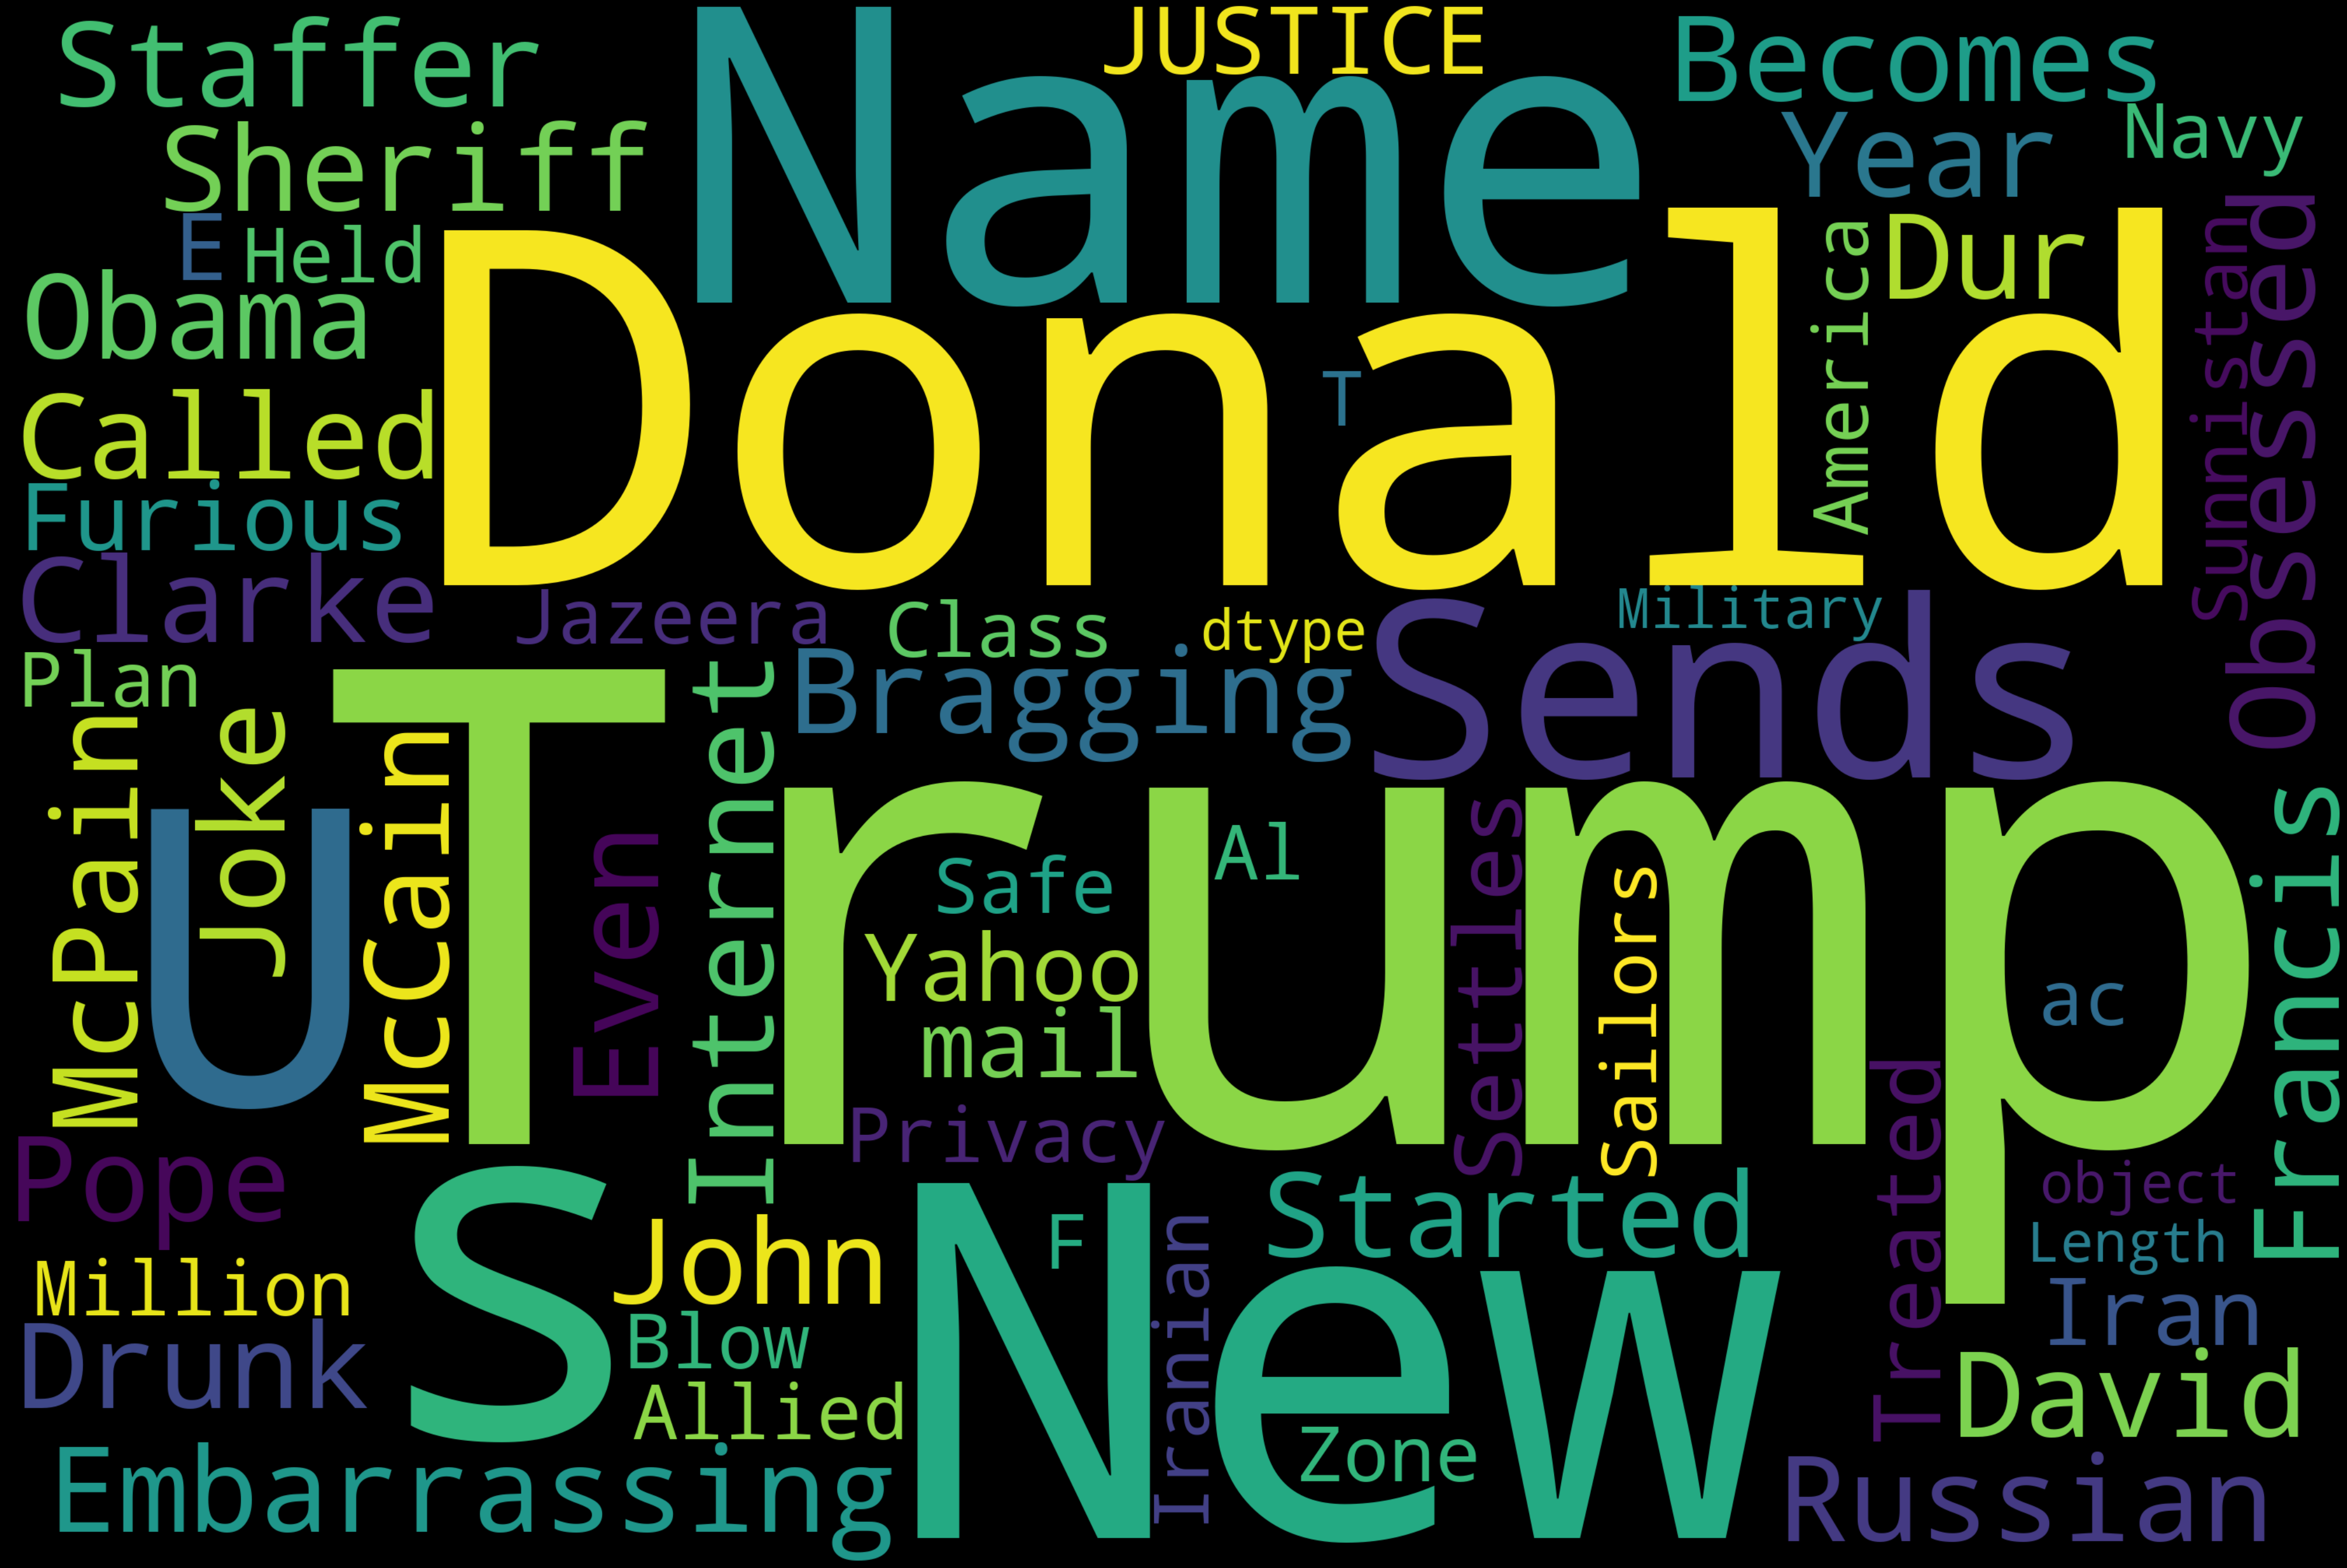

In [21]:
text = fake_news["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**Insights:**
* Most of the fake news revolves around Donald Trump and America
* There are also fake news about privacy, internet etc.,

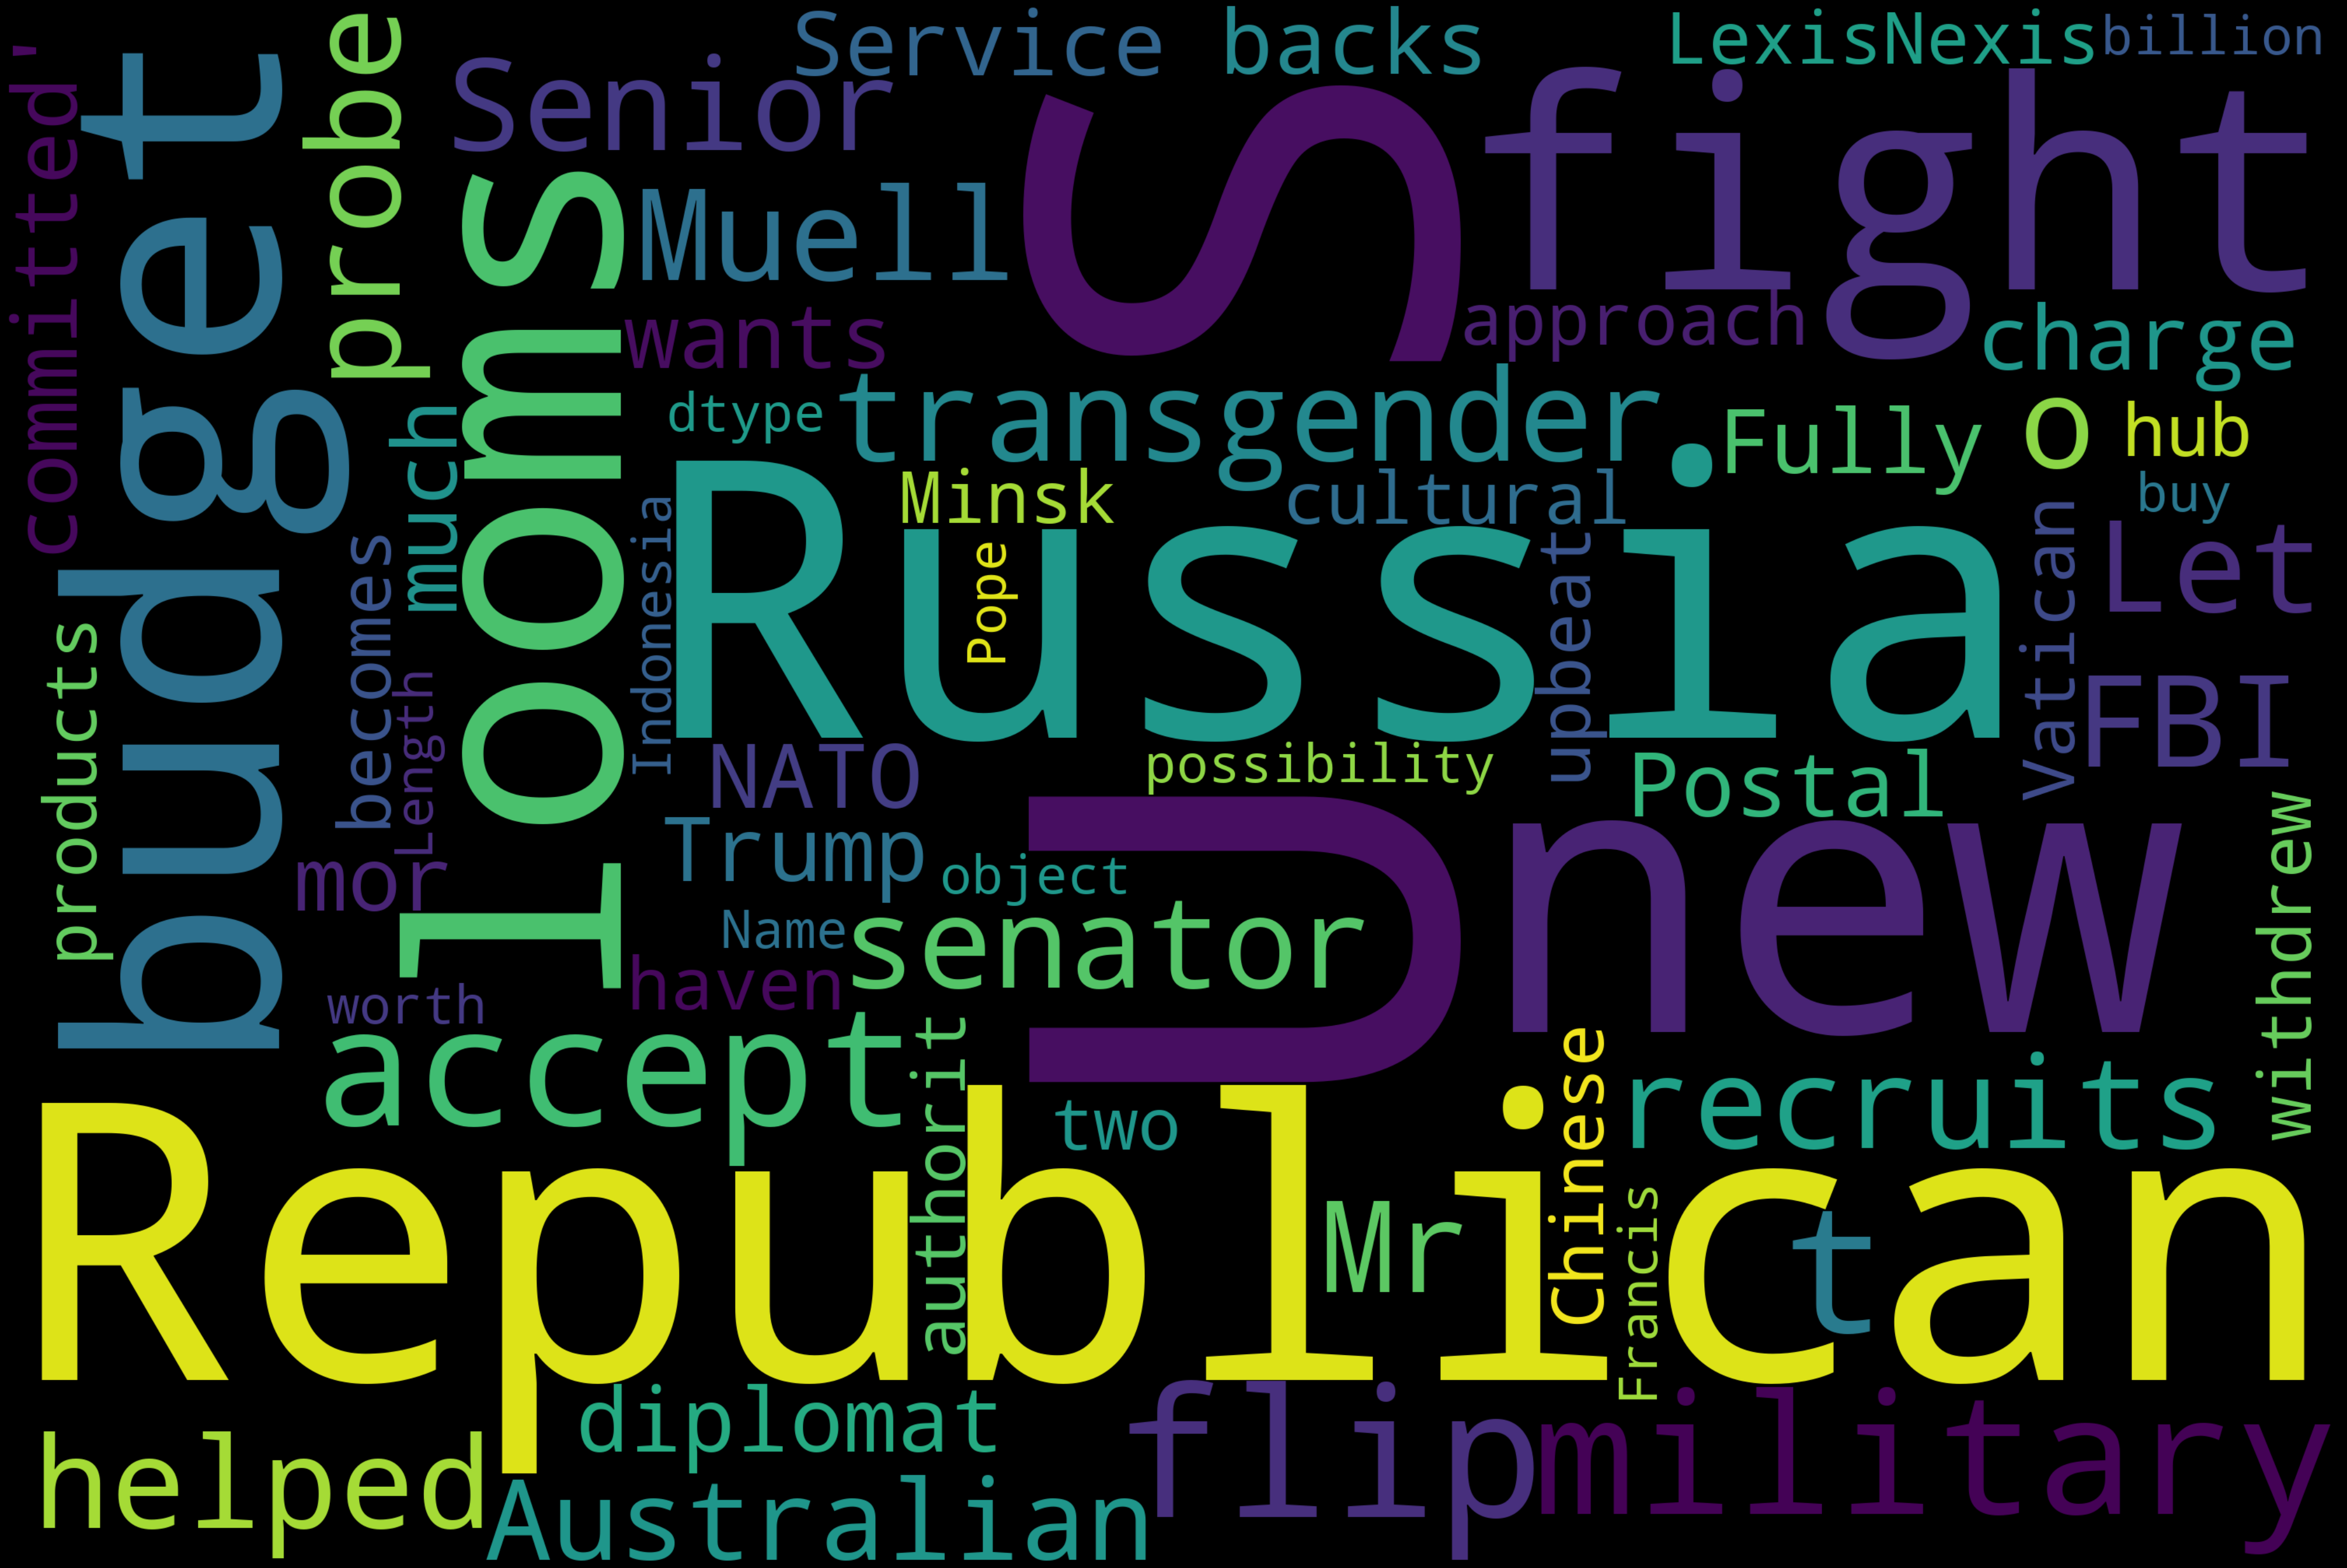

In [22]:
text = true_news["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**Insights:**
* True news doesn't involve much trump instead on Republican Party and Russia
* There are news about Budget,military which comes under government news

## Time series analysis- Fake/True news
Let's look at the timeline of true and fake news that were circulated in the media.

In [23]:
#Creating the count of output based on date
fake=fake_news.groupby(['date'])['output'].count()
fake=pd.DataFrame(fake)

true=true_news.groupby(['date'])['output'].count()
true=pd.DataFrame(true)

#Plotting the time series graph
fig = go.Figure()
fig.add_trace(go.Scatter(
         x=true.index,
         y=true['output'],
         name='True',
    line=dict(color='blue'),
    opacity=0.8))

fig.add_trace(go.Scatter(
         x=fake.index,
         y=fake['output'],
         name='Fake',
    line=dict(color='red'),
    opacity=0.8))

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
        
    
fig.update_layout(title_text='True and Fake News',plot_bgcolor='rgb(248, 248, 255)',yaxis_title='Value')

fig.show()

**Insights:**
* True news got their dominance since Aug 2017. As they are seen at a very higher rates.That is a good sign
* There are few outliers in true news where it was higher than the fake news(Nov 9, 2016 and Apr 7, 2017)
* Our dataset has more fake news than the true one as we can see that we don't have true news data for whole 2015, So the fake news classification will be pretty accurate than the true news getting classified

<a id="section-four"></a>
# Stemming & Vectorizing

## Stemming the reviews
Stemming is a method of deriving root word from the inflected word. Here we extract the reviews and convert the words in reviews to its root word. for example,

* Going->go
* Finally->fina

If you notice, the root words doesn't need to carry a semantic meaning. There is another technique knows as Lemmatization where it converts the words into root words which has a semantic meaning. Simce it takes time. I'm using stemming

In [24]:
#Extracting 'reviews' for processing
news_features=clean_news.copy()
news_features=news_features[['news']].reset_index(drop=True)
news_features.head()

news
0  donald trump sends embarrassing new year’s eve...
1  drunk bragging trump staffer started russian c...
2  sheriff david clarke becomes internet joke thr...
3  trump obsessed even obama’s name coded website...
4  pope francis called donald trump christmas spe...

In [25]:
stop_words = set(stopwords.words("english"))
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['news'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news)   

In [26]:
corpus[1]

'drunk brag trump staffer start russian collus investigationhous intellig committe chairman devin nune go bad day assumpt like mani us christoph steeledossi prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york timesform trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari clintonon top papadopoulo covfef boy trump administr alleg much larger role none damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah elsisi egypt two month elect known former aid set meet world leader trump team trump ran mere coffe boyin may papadopoulo reveal australian diplomat alexand downer russian offici shop around possibl dirt thendemocrat presidenti nomine hillari clinton exactli much mr papadopoulo said night kensington wine room australian alexand downer unclear report state two month later leak democrat email began appear onlin australian offici p

This is how a line looks like now, as computer cannot understand words and their sentiment we need to convert these words into 1's and 0's. To encode it we use TFIDF

## TFIDF(Term Frequency — Inverse Document Frequency)
TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify a word in documents, we generally compute a weight to each word which signifies the importance of the word in the document and corpus. This method is a widely used technique in Information Retrieval and Text Mining.

Here we are splitting as bigram (two words) and consider their combined weight.Also we are taking only the top 5000 words from the news.

In [27]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(news_features['news'])
X.shape

(44888, 5000)

As we have considered 5000 words, we can confirm that we have 5000 columns from the shape.

In [28]:
#Getting the target variable
y=clean_news['output']

### Checking for balance of data
We should be careful about when handling imbalance data. If it is imbalanced, the model will be biased towards the higher frequency class and returns max output

In [29]:
print(f'Original dataset shape : {Counter(y)}')

Original dataset shape : Counter({0: 23471, 1: 21417})


Our dataset is nearly a balanced one. So let's leave balancing it.

## Train-test split(75:25)
Using train test split function we are splitting the dataset into 75:25 ratio for train and test set respectively.

In [30]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

<a id="section-five"></a>
# Model Building: Fake News Classifier
As we have successfully processed the text data, not it is just a normal machine learning problem. Where from the sparse matrix we predict the classes in target feature.

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Model Selection
First select the best peforming model by using cross validaton. Let's consider all the classification algorithm and perform the model selection process

**Note:** I'm not including SVM in this algorithm because it took alot of time to train in my device

In [32]:
#creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
nb_cv=MultinomialNB(alpha=0.1) 
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,nb_cv]

#Printing the accuracy
for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.9660040199274997
Decision Tree Test Accuracy: 0.9343916045123573
KNN Test Accuracy: 0.6119253084088696
Naive Bayes Test Accuracy: 0.9373328405462511


From the results, we can see logistic regression outdone the rest of the algorithms followed by Naive Bayes and Decision Tree.That's great. So let's go with logistic regression with hyperparameter tuning.

## Logistic Regression with Hyperparameter Tuning
We use regularization parameter and penality for parameter tuning. let's see which one to plug.

In [41]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=24.420530945486497, random_state=0)
The mean accuracy of the model is: 0.9803065407235787


From the selected params, we get accuracy. Let's plug and chug

In [40]:
logreg = LogisticRegression(C=24.420530945486497, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.98


### Confusion Matrix
Let's look at the true positive and true negative classified by the model

We have got 98% accuracy. As already discussed before this is a biased dataset and we can easily get such higher accuracy without any effort in processing it. But for classification problems we need to get confusion matrix and check f1 score rather than accuracy

Confusion matrix, without normalization


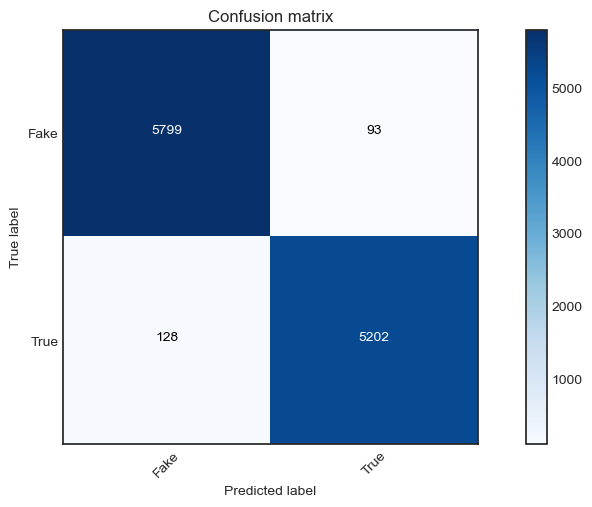

In [42]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Fake','True'])

Check out the diagonal elements(5799+5202), they are correctly predicted records and rest are incorrectly classified by the algorithm. Our model has done well(results are good by the data is biased :P)

### Classification Report
Considering Fake news, we should seriously consider precision score (False positive). We can't afford the mistakes when the model classifies fake news as true which will lead to chaos

In [43]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      5892
           1       0.98      0.98      0.98      5330

    accuracy                           0.98     11222
   macro avg       0.98      0.98      0.98     11222
weighted avg       0.98      0.98      0.98     11222



All our scores are 98%. Certainly unreal to get such values. There are only changes in the support.

## ROC-AUC Curve

This is a very important curve where we decide on which threshold to setup based upon the objective criteria

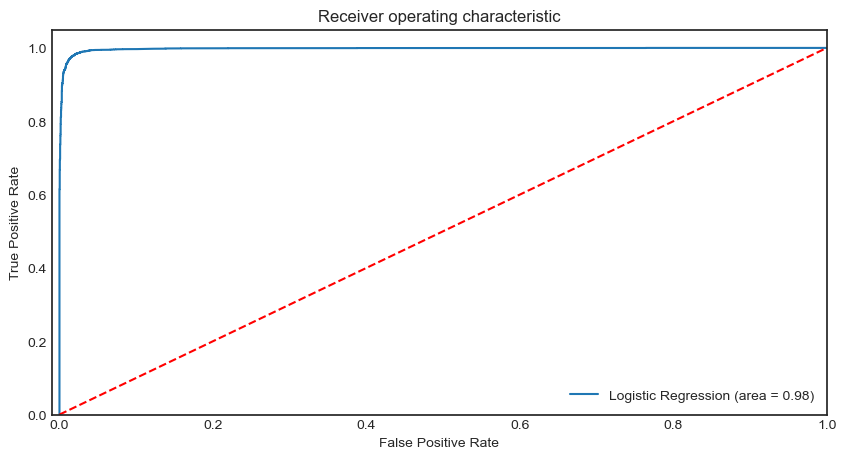

In [44]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

We should consider the AUC score here which is 98%. Very well. All metrics are performing good. The more far left the curve is better our model We can adjust our threshold based on our ROC curve to get results based on model requirements

<a id="section-six"></a>
# Deep learning-LSTM
In this section, we will harness the power of neural networks to discern the authenticity of news articles.

Instead of employing a conventional neural network, such as an Artificial Neural Network (ANN), for classification, we will leverage Long Short-Term Memory (LSTM) networks. LSTMs excel at preserving sequence information, making them well-suited for tasks that demand an understanding of order dependence in sequences. This quality is particularly valuable in complex problem domains like machine translation, speech recognition, and more.


## Embedding layers
Before delving into the creation of embedding layers, we need to determine the vocabulary size. You might wonder, why is vocabulary size important? It plays a crucial role because we intend to employ one-hot encoding for sentences within our corpus when constructing the embedding layers. Each word in the sentences will be represented by an index corresponding to the vocabulary size. Let's set the vocabulary size to 10,000 and infuse some captivating words into the mix.

In [45]:
corpus[1]

'drunk brag trump staffer start russian collus investigationhous intellig committe chairman devin nune go bad day assumpt like mani us christoph steeledossi prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york timesform trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari clintonon top papadopoulo covfef boy trump administr alleg much larger role none damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah elsisi egypt two month elect known former aid set meet world leader trump team trump ran mere coffe boyin may papadopoulo reveal australian diplomat alexand downer russian offici shop around possibl dirt thendemocrat presidenti nomine hillari clinton exactli much mr papadopoulo said night kensington wine room australian alexand downer unclear report state two month later leak democrat email began appear onlin australian offici p

In [46]:
#Setting up vocabulary size
voc_size=10000

#One hot encoding 
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

We can see all the words in the sentences are transformed into their index from the vocabulary we created.

## Padding embedded documents
All neural networks necessitate inputs of uniform shape and size. Nevertheless, when we preprocess and employ textual data as input for our LSTM model, not all sentences share the same length. In essence, some sentences may be lengthier or briefer. To achieve uniformity, we set a standard length of 5000 and apply padding using the pad_sequence() function. Furthermore, we opt for 'pre' padding, adding zeros before the sentences to ensure uniform sentence length

In [47]:
#Setting sentence length
sent_length=5000

#Padding the sentences
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 6253  965 5668]
 [   0    0    0 ... 1005 8383 5668]
 [   0    0    0 ... 6769  861 5668]
 ...
 [   0    0    0 ... 7917 8851 6555]
 [   0    0    0 ... 6208 2780 7260]
 [   0    0    0 ... 3513 2288 6427]]


In [48]:
embedded_docs[1]

array([   0,    0,    0, ..., 1005, 8383, 5668])

We can see all the sentences are of equal length with the addition of zeros infront of the sentences and making all the sentences of length 5000

## LSTM Model
First, we'll establish the foundational model and compile it. The initial layer will be an embedding layer, taking input from the vocabulary size, vector dimensions, and sentence length. Next, we'll introduce a dropout layer with a 30% dropout rate to safeguard against overfitting. Subsequently, an LSTM layer with 100 neurons will follow. To complete the model, we'll employ a final layer with a sigmoid activation function. The compilation of the model will utilize the Adam optimizer and binary cross-entropy as the loss function, as we're dealing with a binary classification task, distinguishing between two possible outcomes.

In [49]:
#Creating the lstm model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100)) #Adding 100 lstm neurons in the layer
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 40)          400000    
                                                                 
 dropout (Dropout)           (None, 5000, 40)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 456501 (1.74 MB)
Trainable params: 456501 (1.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [50]:
len(embedded_docs),y.shape

(44888, (44888,))

## Fitting the LSTM Model
Before fitting to the model, let's consider the padded embedded object as X and y as y itself and convert them into an array.

In [51]:
# Converting the X and y as array
X_final=np.array(embedded_docs)
y_final=np.array(y)

#Check shape of X and y final
X_final.shape,y_final.shape

((44888, 5000), (44888,))

## Evaluation of model
Now, let's predict the output for our test data and evaluate the predicted values with y_test

In [52]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [53]:
# Load Data
true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')
# Data Preprocessing
# Combine and label the data
true_df['label'] = 1
fake_df['label'] = 0
data = pd.concat([true_df, fake_df])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# Tokenization and Padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_seq, maxlen=200, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=200, padding='post', truncating='post')

# LSTM Model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model_lstm.add(LSTM(128))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.fit(X_train_padded, y_train, epochs=5, validation_data=(X_test_padded, y_test))

# Evaluate LSTM Model
y_pred_lstm = model_lstm.predict(X_test_padded)
y_pred_lstm = [1 if val > 0.5 else 0 for val in y_pred_lstm]

Epoch 1/5
1123/1123 [==============================] - 158s 136ms/step - loss: 0.2639 - accuracy: 0.9028 - val_loss: 0.1331 - val_accuracy: 0.9562
Epoch 2/5
1123/1123 [==============================] - 149s 133ms/step - loss: 0.2494 - accuracy: 0.9129 - val_loss: 0.1498 - val_accuracy: 0.9577
Epoch 3/5
1123/1123 [==============================] - 147s 131ms/step - loss: 0.0680 - accuracy: 0.9789 - val_loss: 0.0160 - val_accuracy: 0.9964
Epoch 4/5
1123/1123 [==============================] - 154s 137ms/step - loss: 0.0066 - accuracy: 0.9984 - val_loss: 0.0062 - val_accuracy: 0.9986
Epoch 5/5
281/281 [==============================] - 16s 55ms/step


In [54]:
print("LSTM Classification Report:")
print(classification_report(y_test, y_pred_lstm))

LSTM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4650
           1       1.00      1.00      1.00      4330

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



## Evaluation of model
Now, let's predict the output for our test data and evaluate the predicted values with y_test

Confusion matrix, without normalization


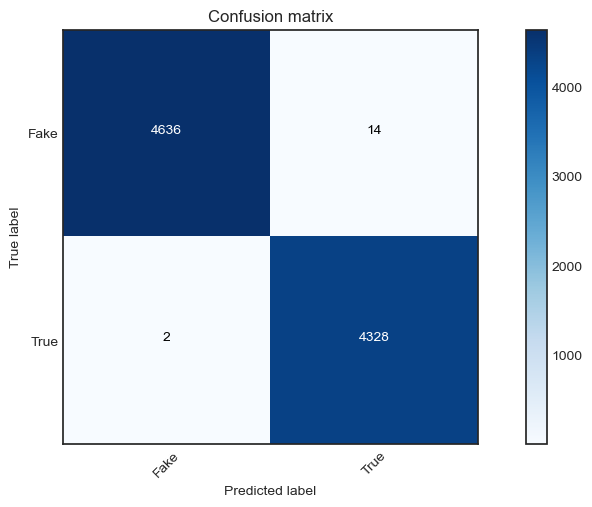

In [55]:
#Creating confusion matrix
#confusion_matrix(y_test,y_pred)
cm = metrics.confusion_matrix(y_test, y_pred_lstm)
plot_confusion_matrix(cm,classes=['Fake','True'])

In [56]:
#Checking for accuracy
accuracy_score(y_test,y_pred_lstm)

0.998218262806236

In [57]:
print(f"accuracy_score:{accuracy_score(y_test,y_pred_lstm).round(4)*100}%")

accuracy_score:99.82%


From the classification report we can see the accuracy value is nearly around 100%. We have to concentrate on precision score and it is 99.82% which is great.

<a id="section-seven"></a>
# Conclusion
Natural Language Processing (NLP) serves as a vital instrument in our ongoing battle against the proliferation of fake news. The effectiveness of NLP models in this endeavor hinges on several crucial factors, chief among them being the intricate interactions and correlations among features. When dealing with categorical features like the 'subject' of news articles, the ability to discern hidden associations and patterns becomes paramount.

Success in fake news detection is inextricably linked to comprehensive feature consideration and engineering. This involves extracting meaningful information from textual data and optimizing predictive performance. By delving deep into these intricacies and meticulously fine-tuning our models, NLP equips us with the tools needed to identify and combat the ever-evolving landscape of misinformation. It empowers us to enhance our understanding of the nuanced world of deceptive content, reinforcing the foundation of trustworthy information and the safeguarding of public discourse.